# ARIMA Modeling

### Learning Objectives
This is meant as a quick checkout to compare the results of our complex LSTM NLP model with that of a simplistic SARIMAX model
We will:
- Conduct and interpret an augmented Dickey-Fuller test for stationarity on several datasets including CPI, Bonds and 3mnth rates.  We will also use CPI as en exogenous variable for the prediction of the other two rates models.
- Construct integrated autoregressive moving average (ARIMA) models for rates .
- Fit and tune a SARIMAX model.

In [54]:
# !pip install scipy statsmodels --upgrade

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

In [93]:
# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [132]:
# Read in data.
bonds = pd.read_parquet('../data/bonds.parquet')
short_rates = pd.read_parquet('../data/three_month_rates.parquet')
cpi = pd.read_parquet('../data/cpi.parquet')
commodities = pd.read_parquet('../data/commodities.parquet')
#data = data.drop(data.index[:2])

In [214]:
cpi.columns

Index(['usa', 'canada', 'europe', 'uk', 'australia', 'brazil', 'india',
       'switzerland', 'japan', 'south korea'],
      dtype='object')

In [133]:
#authors note. these dataframes will be used for exogonous analysis only when training sarimamax models

commodities_diff = commodities.pct_change()
bonds_diff = bonds.pct_change()



In [162]:
prices = commodities_diff.merge(cpi.shift(), left_index=True, right_index=True)

In [134]:
common_indexes = commodities.index.intersection(cpi.index)

# Select rows from commodities dataframe that exist in bonds dataframe
commodities = commodities.loc[common_indexes]
short_rates = short_rates.loc[common_indexes]
cpi = cpi.loc[common_indexes]
bonds = bonds.loc[common_indexes]
commodities_diff = commodities_diff.loc[common_indexes]
bonds_diff = bonds_diff.loc[common_indexes]
cpi_diff = cpi_diff.loc[common_indexes] 

In [175]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    # Set figure size to be (18, 9).
    plt.figure(figsize=(7,3))
    # Iterate through each column name.
    for col in cols:    
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col], label=col)  # Add label parameter to your plot
        
    # Generate title and labels.
    plt.title(title, fontsize=16)
    plt.xlabel(xlab, fontsize=10)
    plt.ylabel(ylab, fontsize=10)
    
    # Create the legend and place it in the upper right corner.
    plt.legend(loc='upper right')
    
    # Enlarge tick marks.
    plt.yticks(fontsize=10)
    plt.xticks(df.index[0::steps], fontsize=8)

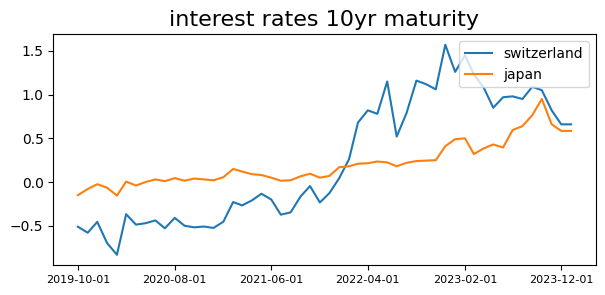

In [213]:
# Generate a time plot of our bus ridership data.
plot_series(bonds, ['switzerland','japan'], title = 'interest rates 10yr maturity', steps=10) #'india','australia', 'switzerland'

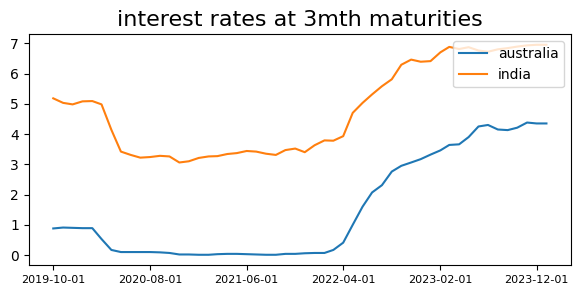

In [220]:
plot_series(short_rates, ['australia','india'], title = 'interest rates at 3mth maturities', steps=10)

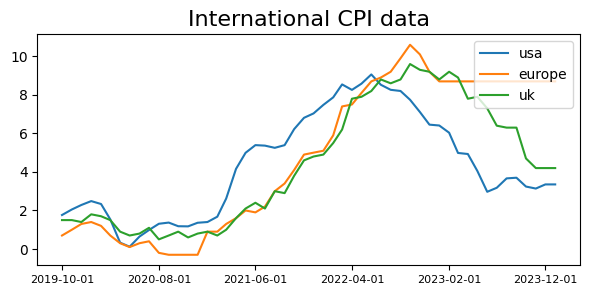

In [215]:
plot_series(cpi, ['usa', 'europe', 'uk'], title = 'International CPI data', steps=10)

In [167]:
commodities.columns

Index(['gold', 'copper', 'crude oil', 'soy'], dtype='object')

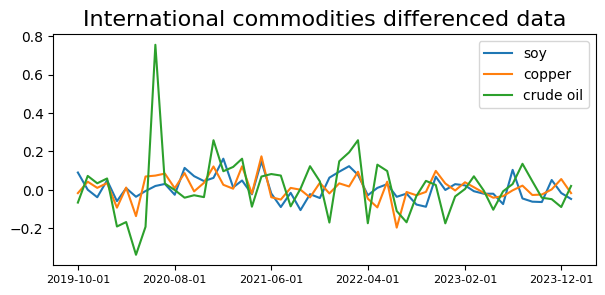

In [221]:
#cols_dict = {"GC": "gold", "HG": "copper", "CL": "crude oil", "ZS": "soy"}
plot_series(commodities_diff, ['soy', 'copper', 'crude oil'], title = 'International commodities differenced data', steps=10)

#### Checking for Stationarity: the Augmented Dickey-Fuller Test

In [110]:
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [118]:
# Run ADF test on (differenced!) data.
# japan and brazil need second order differences to be stationary
adf_df_bonds = pd.DataFrame()

for country in bonds.columns.tolist():
    # Assuming 'interpret_dftest' returns a dictionary of test statistics
    adf_results = interpret_dftest(adfuller(bonds[country].diff().dropna()))
    
    # Convert the results to a DataFrame and append it to 'adf_df'
    adf_df[country] = adf_results
adf_df_bonds

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
Test Statistic,-4.540001,-4.622160,-5.404654,-5.865958e+00,-5.481182,-2.286662,-7.119090e+00,-8.881716e+00,-1.844126,-5.859925e+00
p-value,0.000166,0.000118,0.000003,3.325226e-07,0.000002,0.176306,3.763250e-10,1.312516e-14,0.358785,3.429484e-07


In [179]:
# Run ADF test on CPI data.
# India and brazil need second order differences to be stationary
adf_df_cpi = pd.DataFrame()

for country in cpi.columns.tolist():
    # Assuming 'interpret_dftest' returns a dictionary of test statistics
    adf_results = interpret_dftest(adfuller(cpi[country].diff().dropna()))
    
    # Convert the results to a DataFrame and append it to 'adf_df'
    adf_df_cpi[country] = adf_results
adf_df_cpi

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
Test Statistic,-3.126097,-4.714633,-4.388798,-2.650703,-7.003209e+00,-2.324225,-2.494568,-3.823252,-6.872975e+00,-5.132303
p-value,0.024681,0.000079,0.000311,0.082964,7.232207e-10,0.164274,0.116802,0.002678,1.499176e-09,0.000012


In [180]:
# Run ADF test on CPI data.
# India and brazil need second order differences to be stationary
adf_df_commodities = pd.DataFrame()

for country in commodities.columns.tolist():
    # Assuming 'interpret_dftest' returns a dictionary of test statistics
    adf_results = interpret_dftest(adfuller(commodities[country].pct_change().dropna()))
    
    # Convert the results to a DataFrame and append it to 'adf_df'
    adf_df_commodities[country] = adf_results
adf_df_commodities

,gold,copper,crude oil,soy
Test Statistic,-7.236547e+00,-7.506578e+00,-6.559944e+00,-5.757972e+00
p-value,1.932855e-10,4.119483e-11,8.430381e-09,5.760285e-07


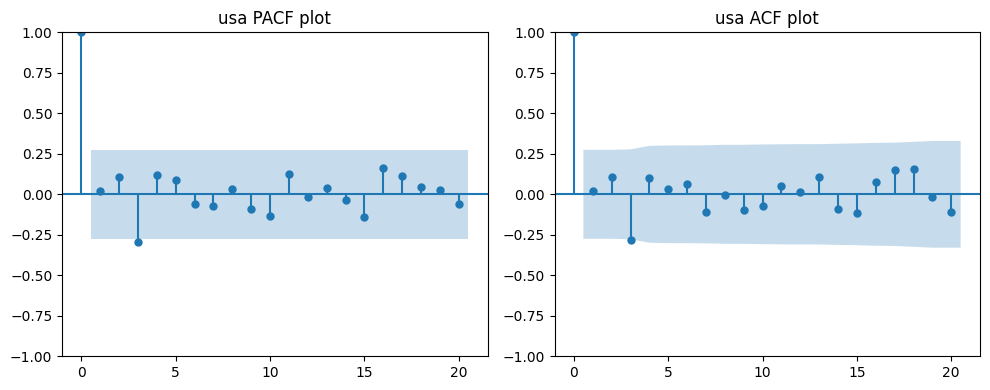

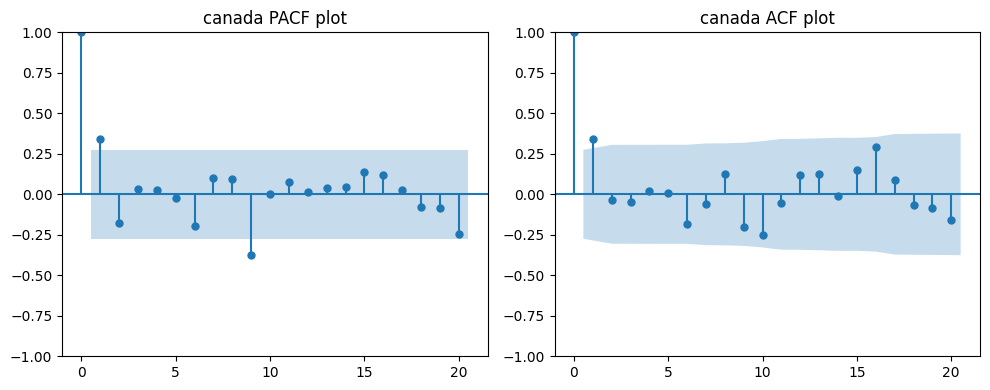

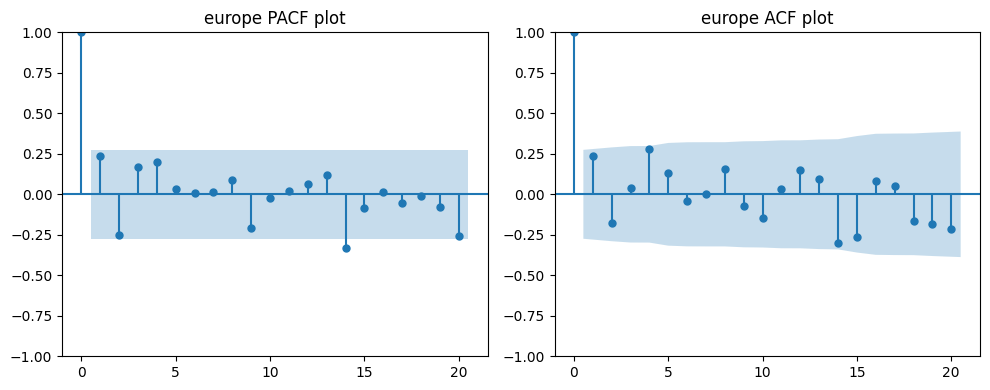

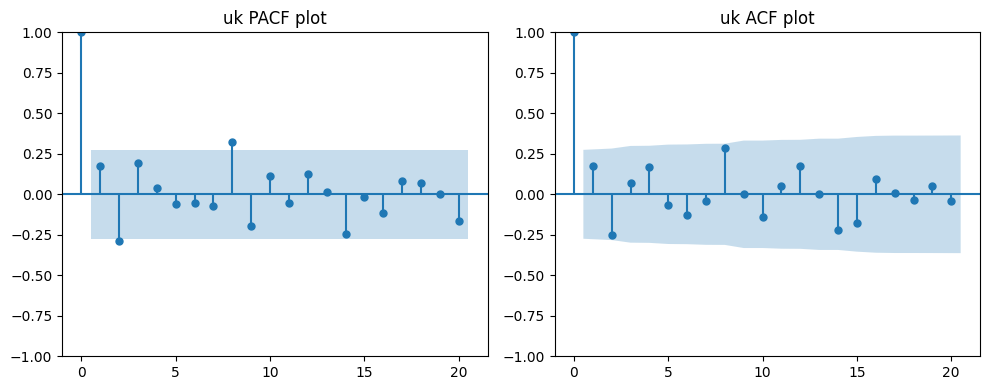

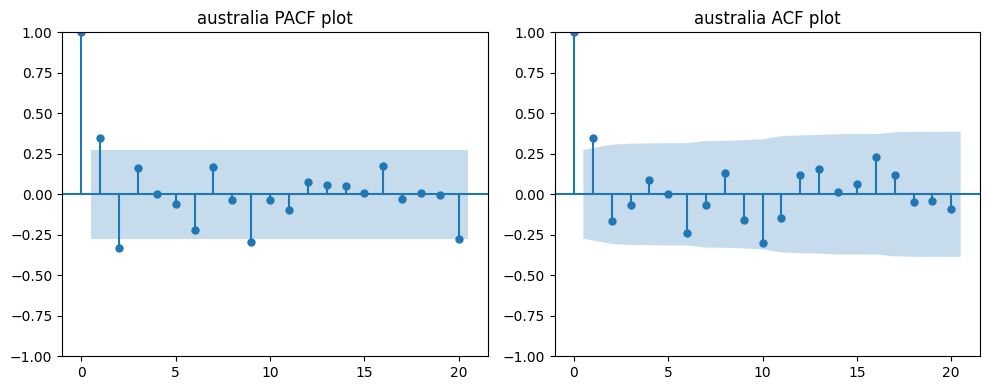

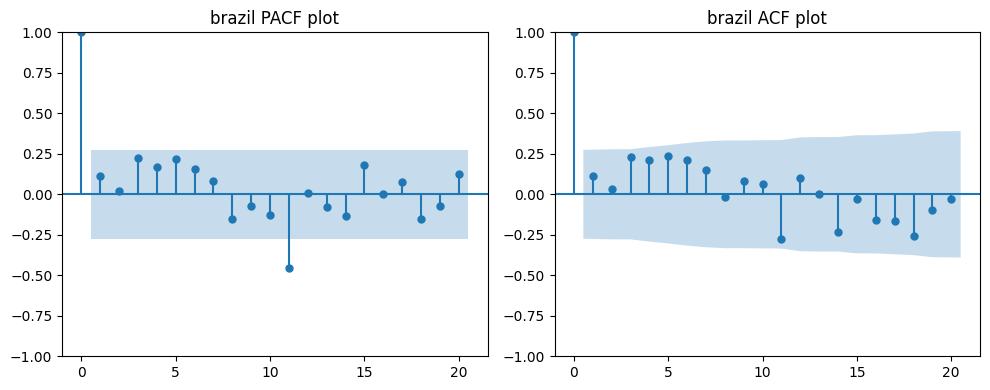

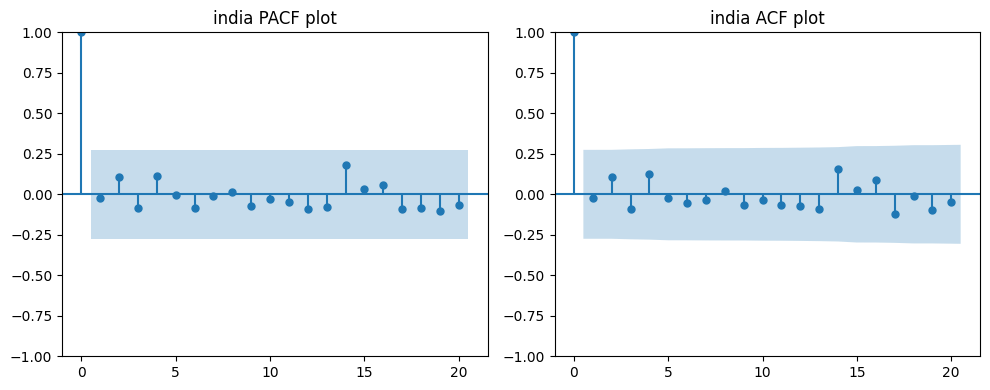

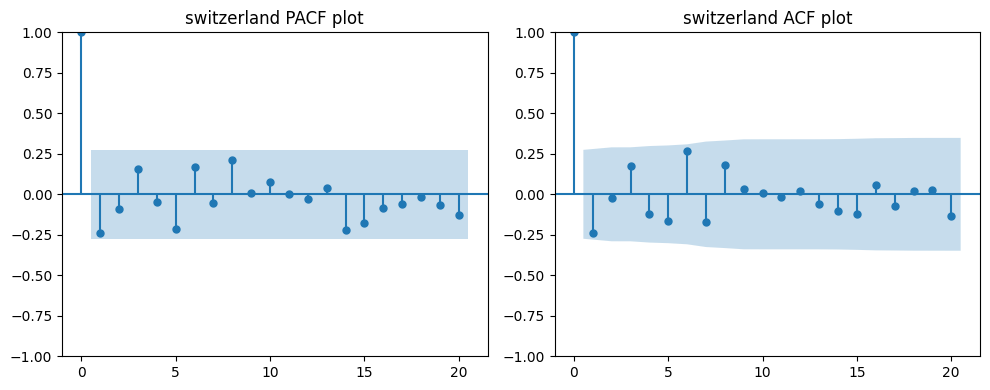

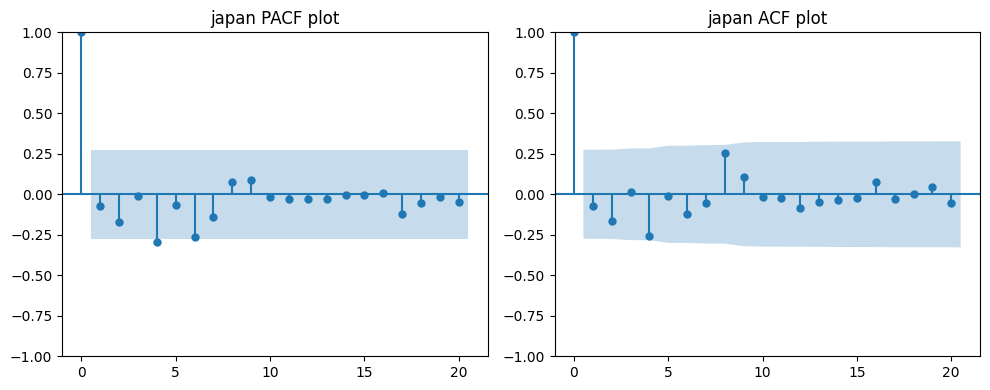

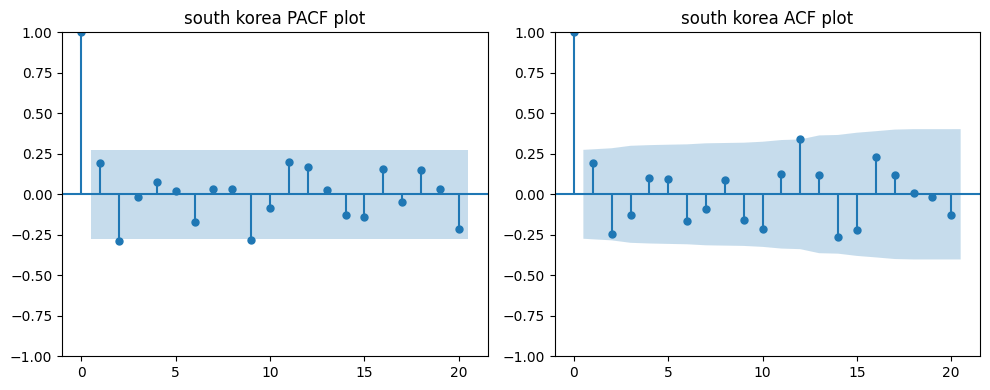

In [232]:
for country in bonds.columns.tolist():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Generate PACF plot.
    plot_pacf(bonds[country].diff().dropna(), lags=20, ax=ax1)
    ax1.set_title(f'{country} PACF plot')
    
    # Generate ACF plot.
    plot_acf(bonds[country].diff().dropna(), lags=20, ax=ax2)
    ax2.set_title(f'{country} ACF plot')
    
    plt.tight_layout()
    plt.show()


<details><summary>How would you interpret the partial autocorrelation plot here?</summary>

### Interpret the partial autocorrelation plot.
1. The partial autocorrelation plot above shows that observations are highly correlated with one another. 
2. **However, the partial autocorrelation plot checks for the correlation between observations, conditioning on all lower-lag autocorrelations.** (That is, the partial autocorrelation between $Y_t$ and $Y_{t-2}$ is the correlation between $Y_t$ and $Y_{t-2}$ that has already taken into account the autocorrelation between $Y_t$ and $Y_{t-1}$.)
3. The blue band indicates the 95% confidence interval for these correlations.
    - Observations inside the blue band mean that there is no significant correlations between $Y_t$ and $Y_{t-k}$ for lag $k$, **accounting for all lower-order lags**.
    - Observations outside the blue band mean that there **is** a significant correlation between $Y_t$ and $Y_{t-k}$ for lag $k$, **accounting for all lower-order lags**.
</details>

In [192]:
prices = prices.fillna(method='ffill').fillna(method='bfill')

C:\Users\USER\AppData\Local\Temp\ipykernel_18268\4215695368.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices = prices.fillna(method='ffill').fillna(method='bfill')


In [231]:
# Create train-test split.
X_10yr_train, X_10yr_test, y_10yr_train, y_10yr_test = train_test_split(prices,
                                                    bonds['usa'],
                                                    test_size = 0.3,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!

# Create train-test split.
X_cpi_train, X_cpi_test, y_cpi_train, y_cpi_test = train_test_split(commodities_diff,
                                                    cpi['usa'],
                                                    test_size = 0.3,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!

# Create train-test split.
X_10yr_train, X_10yr_test, y_10yr_eu_train, y_10yr_eu_test = train_test_split(prices,
                                                    bonds['europe'],
                                                    test_size = 0.3,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!

### Fit an ARIMA model.


In [68]:
# Import ARIMA model.
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Fit a SARIMA(0, 2, 1) x (0, 0, 1, 12) model.
sarima = SARIMAX(endog=y_10yr_train.astype(float),
                order = (3, 1, 2), seasonal_order=(0, 0, 0, 0),
                exog = X_10yr_train.astype(float))


# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
overlap = model.predict(start = datetime(2019, 11, 1), end = datetime(2022, 9, 1),
                     exog = X_10yr_train.astype(float))
preds = model.predict(start = datetime(2022, 10, 1), end = datetime(2024, 1, 1),
                     exog = X_10yr_test.astype(float))

# Evaluate predictions.
print(model.aic)

# Plot data.
plt.figure(figsize=(6,4))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.plot(overlap, color = 'red')
plt.title(label = 'US 10 year rates with SARIMAX(3, 1, 3) x (0, 0, 0, 0) Predictions', fontsize=10)
plt.show();

### Manual GridSearch


In [204]:
start = X_10yr_test.index[0]
stop = X_10yr_test.index[-1]
y_start = y_10yr_test.index[0]
y_stop = y_cpi_test.index[-1]

print(y_start, y_stop)

2022-10-01 00:00:00 2024-01-01 00:00:00


In [240]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(0, 2):
            for S in range(0,13,4):
                try:
                    print(f'Attempting to fit SARIMAX(0,2,1)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = y_10yr_train,
                                     order = (3, 1, 3),              # (p, d, q)
                                     seasonal_order = (P, D, Q, S),  # (P, D, Q, S)
                                     exog = X_10yr_train) 
 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=start,
                                          end=stop,
                                          exog=X_10yr_test)

                    # Evaluate predictions.
                    print(f'The MSE for (0, 1, 1)x({P},{D},{Q},{S}) is: {mean_squared_error(y_10yr_test, preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(y_10yr_test, preds):
                        best_mse = mean_squared_error(y_10yr_test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(3, 1, 3)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(0,2,1)x(0,0,0,0)


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

The MSE for (0, 1, 1)x(0,0,0,0) is: 0.19295071998036722
Attempting to fit SARIMAX(0,2,1)x(0,0,0,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,0,0,4) is: 0.19295071998036722
Attempting to fit SARIMAX(0,2,1)x(0,0,0,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,0,0,8) is: 0.19295071998036722
Attempting to fit SARIMAX(0,2,1)x(0,0,0,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


The MSE for (0, 1, 1)x(0,0,0,12) is: 0.19295071998036722
Attempting to fit SARIMAX(0,2,1)x(0,1,0,0)
Attempting to fit SARIMAX(0,2,1)x(0,1,0,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,1,0,4) is: 18.014317075310537
Attempting to fit SARIMAX(0,2,1)x(0,1,0,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,1,0,8) is: 0.9217063761180674
Attempting to fit SARIMAX(0,2,1)x(0,1,0,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,1,0,12) is: 0.33364397110375554
Attempting to fit SARIMAX(0,2,1)x(0,0,1,0)
Attempting to fit SARIMAX(0,2,1)x(0,0,1,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,0,1,4) is: 0.2711087499269582
Attempting to fit SARIMAX(0,2,1)x(0,0,1,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,0,1,8) is: 1.1032299579485594
Attempting to fit SARIMAX(0,2,1)x(0,0,1,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


The MSE for (0, 1, 1)x(0,0,1,12) is: 0.3851526805874381
Attempting to fit SARIMAX(0,2,1)x(0,1,1,0)
Attempting to fit SARIMAX(0,2,1)x(0,1,1,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,1,1,4) is: 0.9755819590084558
Attempting to fit SARIMAX(0,2,1)x(0,1,1,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,1,1,8) is: 0.17496468544757657
Attempting to fit SARIMAX(0,2,1)x(0,1,1,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,1,1,12) is: 0.17448809508733798
Attempting to fit SARIMAX(0,2,1)x(0,0,2,0)
Attempting to fit SARIMAX(0,2,1)x(0,0,2,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,0,2,4) is: 0.9455498299516307
Attempting to fit SARIMAX(0,2,1)x(0,0,2,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,0,2,8) is: 0.5955897055262773
Attempting to fit SARIMAX(0,2,1)x(0,0,2,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 1)x(0,0,2,12) is: 0.25696075731345014
Attempting to fit SARIMAX(0,2,1)x(0,1,2,0)
Attempting to fit SARIMAX(0,2,1)x(0,1,2,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,1,2,4) is: 2.079430535890416
Attempting to fit SARIMAX(0,2,1)x(0,1,2,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(0,1,2,8) is: 0.19084612642983734
Attempting to fit SARIMAX(0,2,1)x(0,1,2,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The MSE for (0, 1, 1)x(0,1,2,12) is: 0.17927889013978243
Attempting to fit SARIMAX(0,2,1)x(1,0,0,0)
Attempting to fit SARIMAX(0,2,1)x(1,0,0,4)


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

The MSE for (0, 1, 1)x(1,0,0,4) is: 0.4655503660505076
Attempting to fit SARIMAX(0,2,1)x(1,0,0,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,0,0,8) is: 0.5684249485675203
Attempting to fit SARIMAX(0,2,1)x(1,0,0,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


The MSE for (0, 1, 1)x(1,0,0,12) is: 0.3347694334048208
Attempting to fit SARIMAX(0,2,1)x(1,1,0,0)
Attempting to fit SARIMAX(0,2,1)x(1,1,0,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,1,0,4) is: 8.88799994722569
Attempting to fit SARIMAX(0,2,1)x(1,1,0,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,1,0,8) is: 0.21896421581162545
Attempting to fit SARIMAX(0,2,1)x(1,1,0,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,1,0,12) is: 0.14332830318469572
Attempting to fit SARIMAX(0,2,1)x(1,0,1,0)
Attempting to fit SARIMAX(0,2,1)x(1,0,1,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,0,1,4) is: 2.137539137573756
Attempting to fit SARIMAX(0,2,1)x(1,0,1,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,0,1,8) is: 1.3679376818184807
Attempting to fit SARIMAX(0,2,1)x(1,0,1,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


The MSE for (0, 1, 1)x(1,0,1,12) is: 0.5516258454028298
Attempting to fit SARIMAX(0,2,1)x(1,1,1,0)
Attempting to fit SARIMAX(0,2,1)x(1,1,1,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,1,1,4) is: 14.74199012365418
Attempting to fit SARIMAX(0,2,1)x(1,1,1,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,1,1,8) is: 0.241828601291392
Attempting to fit SARIMAX(0,2,1)x(1,1,1,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,1,1,12) is: 0.14448625166415108
Attempting to fit SARIMAX(0,2,1)x(1,0,2,0)
Attempting to fit SARIMAX(0,2,1)x(1,0,2,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,0,2,4) is: 1.0300200660425283
Attempting to fit SARIMAX(0,2,1)x(1,0,2,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,0,2,8) is: 0.733095445268577
Attempting to fit SARIMAX(0,2,1)x(1,0,2,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 1)x(1,0,2,12) is: 0.2534279950286653
Attempting to fit SARIMAX(0,2,1)x(1,1,2,0)
Attempting to fit SARIMAX(0,2,1)x(1,1,2,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,1,2,4) is: 1.9406611036726864
Attempting to fit SARIMAX(0,2,1)x(1,1,2,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(1,1,2,8) is: 0.2078586367362935
Attempting to fit SARIMAX(0,2,1)x(1,1,2,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The MSE for (0, 1, 1)x(1,1,2,12) is: 0.15031245841318308
Attempting to fit SARIMAX(0,2,1)x(2,0,0,0)
Attempting to fit SARIMAX(0,2,1)x(2,0,0,4)


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

The MSE for (0, 1, 1)x(2,0,0,4) is: 0.24309352815196536
Attempting to fit SARIMAX(0,2,1)x(2,0,0,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(2,0,0,8) is: 0.3654511735787661
Attempting to fit SARIMAX(0,2,1)x(2,0,0,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


The MSE for (0, 1, 1)x(2,0,0,12) is: 0.9451060544966223
Attempting to fit SARIMAX(0,2,1)x(2,1,0,0)
Attempting to fit SARIMAX(0,2,1)x(2,1,0,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(2,1,0,4) is: 0.4124704925209221
Attempting to fit SARIMAX(0,2,1)x(2,1,0,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(2,1,0,8) is: 0.2012594545270819
Attempting to fit SARIMAX(0,2,1)x(2,1,0,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The MSE for (0, 1, 1)x(2,1,0,12) is: 0.20382804177426725
Attempting to fit SARIMAX(0,2,1)x(2,0,1,0)
Attempting to fit SARIMAX(0,2,1)x(2,0,1,4)


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

The MSE for (0, 1, 1)x(2,0,1,4) is: 0.45311965457951353
Attempting to fit SARIMAX(0,2,1)x(2,0,1,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(2,0,1,8) is: 0.7465241933129307
Attempting to fit SARIMAX(0,2,1)x(2,0,1,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


The MSE for (0, 1, 1)x(2,0,1,12) is: 0.5049227800389591
Attempting to fit SARIMAX(0,2,1)x(2,1,1,0)
Attempting to fit SARIMAX(0,2,1)x(2,1,1,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(2,1,1,4) is: 0.5436997003840514
Attempting to fit SARIMAX(0,2,1)x(2,1,1,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(2,1,1,8) is: 0.2058595195376508
Attempting to fit SARIMAX(0,2,1)x(2,1,1,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The MSE for (0, 1, 1)x(2,1,1,12) is: 0.15606930634834487
Attempting to fit SARIMAX(0,2,1)x(2,0,2,0)
Attempting to fit SARIMAX(0,2,1)x(2,0,2,4)


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as 

The MSE for (0, 1, 1)x(2,0,2,4) is: 0.8786962442179735
Attempting to fit SARIMAX(0,2,1)x(2,0,2,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(2,0,2,8) is: 0.6807321640908274
Attempting to fit SARIMAX(0,2,1)x(2,0,2,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 1)x(2,0,2,12) is: 0.6158776735650605
Attempting to fit SARIMAX(0,2,1)x(2,1,2,0)
Attempting to fit SARIMAX(0,2,1)x(2,1,2,4)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(2,1,2,4) is: 0.5008608365154587
Attempting to fit SARIMAX(0,2,1)x(2,1,2,8)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

The MSE for (0, 1, 1)x(2,1,2,8) is: 0.20293716391213945
Attempting to fit SARIMAX(0,2,1)x(2,1,2,12)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The MSE for (0, 1, 1)x(2,1,2,12) is: 0.15697950634301555
Our model that minimizes MSE on the testing data is the SARIMAX(3, 1, 3)x(1,1,0,12).
This model has an MSE of 0.14332830318469572.


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9.53304463087471


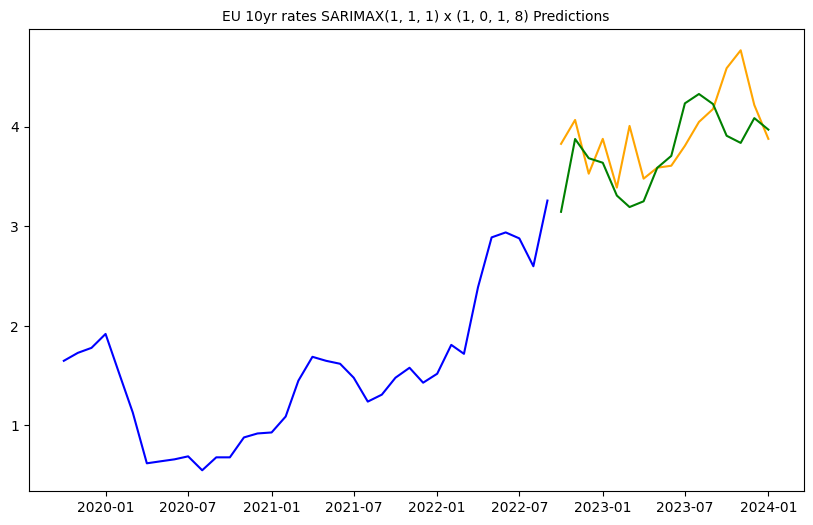

In [238]:
# Fit a SARIMA(0, 2, 1) x (0, 1, 2, 4) model.
sarima = SARIMAX(endog = y_10yr_eu_train,
                                     order = (1, 1, 1),              # (p, d, q)
                                     seasonal_order = (1, 0, 1, 8),  # (P, D, Q, S)
                                     exog = X_10yr_train) 

# Fit SARIMA model.
model = sarima.fit()

print(model.aic)

# Generate predictions based on test set.
preds = model.predict(start = start,
                     end = stop,
                     exog = X_10yr_test)

# Evaluate predictions.

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'EU 10yr rates SARIMAX(1, 1, 1) x (1, 0, 1, 8) Predictions', fontsize=10)
plt.show();

## Takeaways

While we GridSearched over a range of values for the parameters in our SARIMAX model, our model here doesn't look *that* great. Why might that be?

- Looking at the original time plot of our data, when we split our data into the training and the testing sets, it appears that our testing data looks a bit different from our training data. (Obviously this will affect our model, since we only fit on our testing set!) This isn't something we often have much control over.
- There are many, many factors that affect the number of people who take the bus in Portland.
    - The number of bus passengers in the past.
    - Precipitation.
    - Temperature.
    - The population of Portland.
    - The price of cars. (e.g. if cars got cheaper around 1980, perhaps more people began taking cars instead of buses.)
    - Other alternative modes of transportation. (e.g. are there other forms of public transportation, like a train/subway that may affect the number of passengers?)
- **Forecasting time series is exceptionally difficult to do well!** We're using the past to predict the future, and there aren't guarantees that the future is necessarily going to be reflective of the past.